# To Do list: 
- [DO] Run test on new version of PMW
    - Scenario 1: Alice and Bob use disjoint parts of the data set. Any update one makes uniformly reweights the others which may make it less accurate
    - Scenario 2: Alice and Bob have conflicting classes of queries that are incompatible. Alice asks singleton queries Bob asks range queries
- [DO] Try to create an even more adversarial setting where Alice tries to take all the updates (i.e., give Alice more queries than Bob)

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

In [2]:
def pmw2(workload, x, T, eps=0.01, k=0, show_messages=True, to_return='pd', analyst_labels = [],
       show_plot=False, show_failure_step=True):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries. New arguments to allow for optimizing the amount of
    privacy budget used in each step.
    
    to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query (query, d_t_hat, updated, algo_ans, real_ans, abs_error, 
        rel_error). 
        - if 'update_count', pmw() returns the update count for the total
        amount of queries

    - W = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    - eps = privacy budget
    - k = number of update steps
    - T  = update threshold
    """ 
    
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    eta = (math.log(m, np.e) ** (1 / 4)) / (math.sqrt(n))
    # Set k to be the desired number of update rounds
    if k==0: # essentially, if k hasn't been changed from its default value, use the length of the workload
        k = len(workload)  # num of queries
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    # synthetic databases at time 0 (prior to any queries)
    y_t = np.ones(m) / m
    x_t = np.ones(m) / m

    # append to list of databases y_t and x_t
    x_list = [x_t]
    
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = []
    d_t_hat_list = []
    
    failure_mode = False # if reaches failure, failure mode because true and only runs lazy rounds
    
    def lazy_round():
        update_list.append('no')
        pmw_answers.append(np.dot(query, x_list[time]))
        x_list.append(x_list[time].round(3))
        
    
    #inititate first instance of SVT with half the budget and k updates
    #will be reset in the main loop
    SVTtrigger = False 
    SVTepsilon1 =((eps/2)/2)
    SVTepsilon2 = ((eps/2)/2)
    rho = np.random.laplace(loc=0, scale=(1/SVTepsilon1), size=1)[0]
    # iterate through time 
    for time, query in enumerate(workload):
        # Do one round of sparce vector technique 
        
        # compute noisy answer by adding Laplacian noise
        a_t = np.random.laplace(loc=0, scale=(2*k/SVTepsilon2), size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + a_t

        # difference between noisy and maintained histogram answer
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        

        # lazy round: use maintained histogram to answer the query
        if (abs(d_t_hat) <= T + rho) or failure_mode:
            d_t_hat_list.append(d_t_hat)
            lazy_round()
            continue

        # update round: update histogram and return noisy answer
        else:
            update_times.append(time)
            #make a new noisy query answer using some of the leftover budget
            a_t = np.random.laplace(loc=0, scale=(2*k/eps), size=1)[0]
            a_t_hat = (np.dot(query, x_norm)*n ) + a_t
            d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
            d_t_hat_list.append(d_t_hat)
            
            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i, v in enumerate(y_t):
                #y_t[i] = x_list[time][i] * math.exp(-eta * r_t[i])
                y_t[i] = x_list[time][i] * math.exp((d_t_hat/(2*n)) * query[i])
            
            #print(d_t_hat)
            #print(query)
            #print(x_list[time])
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            if update_count >= k: # threshold for num updates is reached, enter failure_mode
                failure_mode = True
                if show_failure_step:
                    print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
            else: # threshold for num updates is not reached yet
                x_list.append(x_t.round(3))
                update_list.append('yes') # increment number of updates counter
                pmw_answers.append(a_t_hat / np.sum(x))
                
    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    
    def print_outputs():
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Updated Database = {x_t}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{T=}\n')
        print(f'Error Scale Query Answer= {2*((2*k/eps)**2)}\n')
        print(f'Error Scale SVT= {2*((2*k/SVTepsilon2)**2)}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
    
    def plot_error():
        """Plot absolute and relative error"""
        plt.xticks(range(0, k, 5))
        plt.title('Error across queries:')
        #rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[abs_line]) #,rel_line])
    
    if show_messages:
        print_outputs()
        
    if show_plot: 
        plot_error()
        
    if to_return == "update_count":
        return update_count

    if to_return == "pd":
        x_list.pop(0).tolist() # remove the first synthetic database to keep length of lists consistent-x_list[t] represents the synthetic database at the end of time t
        
        
        d = {
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'queries': workload.tolist(), 
            'updated': update_list,
            'abs_error': abs_error,               
#            'rel_error': rel_error,
            'synthetic database': x_list,
            'analyst': analyst_labels,
            'd_t_hat': d_t_hat_list, 

             }
        test_data = pd.DataFrame(data=d)
        test_data = test_data.round(3)
        return test_data

In [3]:
x_small = np.array([100, 800, 130, 120, 900, 140, 170, 170])
normalized = x_small / x_small.sum()
print(normalized)
m = x_small.size  # database len
n = x_small.sum()
print(f'the threshold for failure is {n * math.log(m, np.e) ** (1 / 2)}')

[0.03952569 0.31620553 0.0513834  0.04743083 0.35573123 0.05533597
 0.06719368 0.06719368]
the threshold for failure is 3648.328023100234


Failure mode reached at query number 61: [1. 0. 1. 1. 0. 0. 0. 0.]
Original database: [100 800 130 120 900 140 170 170]

Normalized database: [0.03952569 0.31620553 0.0513834  0.04743083 0.35573123 0.05533597
 0.06719368 0.06719368]

Updated Database = [0.08608135 0.22244708 0.08418945 0.0889192  0.12959073 0.12959073
 0.12959073 0.12959073]

Update Count = 30

T=250

Error Scale Query Answer= 7200.0

Error Scale SVT= 115200.0

Update Parameter Scale = 0.023874067550865182

delta=5.044132199178336e-05



,algo_ans,real_ans,queries,updated,abs_error,synthetic database,analyst,d_t_hat
0,0.375,0.415,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",no,0.040,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,201.675
1,0.250,0.091,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",no,0.159,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,40.273
2,0.500,0.455,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",no,0.045,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,-132.849
3,0.461,0.407,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.054,"[0.128, 0.128, 0.128, 0.123, 0.123, 0.123, 0.1...",Alice,217.814
4,0.049,0.047,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",yes,0.002,"[0.129, 0.129, 0.129, 0.119, 0.124, 0.124, 0.1...",Alice,-186.884
5,0.402,0.403,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",yes,0.001,"[0.13, 0.13, 0.128, 0.12, 0.123, 0.123, 0.123,...",Alice,64.039
6,0.377,0.364,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",yes,0.013,"[0.128, 0.136, 0.126, 0.126, 0.121, 0.121, 0.1...",Alice,320.728
7,0.347,0.364,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",yes,0.017,"[0.127, 0.14, 0.125, 0.13, 0.12, 0.12, 0.12, 0...",Alice,214.103
8,0.382,0.138,"[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",no,0.244,"[0.127, 0.14, 0.125, 0.13, 0.12, 0.12, 0.12, 0...",Alice,33.158
9,0.041,0.040,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.002,"[0.122, 0.14, 0.125, 0.13, 0.12, 0.12, 0.12, 0...",Alice,-216.711


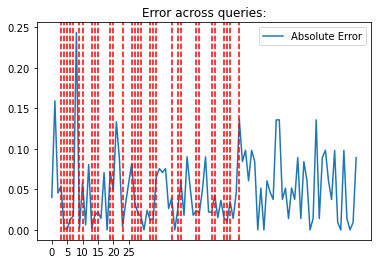

In [4]:
random_array = np.random.randint(2, size=(100,4))
zero_array = np.zeros((100,4))
alice = np.hstack((random_array, zero_array))
bob = np.hstack((zero_array, random_array))
pd.set_option("display.max_rows", None, "display.max_columns", None)
output = pmw2(workload=alice, x=x_small, eps=1, T=250, k=30, to_return='pd', 
              analyst_labels=['Alice'] * 100, show_plot=True)
output

Failure mode reached at query number 48: [0. 0. 0. 0. 0. 0. 0. 0.]
Original database: [100 800 130 120 900 140 170 170]

Normalized database: [0.03952569 0.31620553 0.0513834  0.04743083 0.35573123 0.05533597
 0.06719368 0.06719368]

Updated Database = [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]

Update Count = 30

T=100

Error Scale Query Answer= 7200.0

Error Scale SVT= 115200.0

Update Parameter Scale = 0.023874067550865182

delta=5.044132199178336e-05



,algo_ans,real_ans,queries,updated,abs_error,synthetic database,analyst,d_t_hat
0,0.000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",no,0.000,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,37.398
1,-0.037,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.037,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,-93.382
2,-0.050,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.050,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,-125.565
3,-0.049,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.049,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,-122.841
4,-0.004,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.004,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,-10.397
5,0.000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",no,0.000,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,-73.474
6,0.000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",no,0.000,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,2.839
7,-0.040,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.040,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,-100.533
8,-0.014,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.014,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,-34.280
9,0.002,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.002,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,4.663


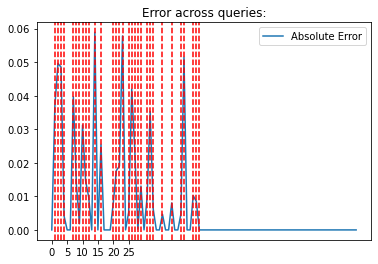

In [5]:
output = pmw2(workload=np.zeros((100,8)), x=x_small, eps=1, T=100, k=30, to_return='pd', 
              analyst_labels=['Alice'] * 100, show_plot=True)
output


In [6]:
x_small.sum()

2530

Q1: Why does 25 return 0.015 instead of 0 for the error?

# Failure Scenario:
Alice and Bob are analysts who query from a database that uses private multiplicative weights in an online setting. 

#### Database and Queries:
- database: [1, 8, 1, 1, 1, 9, 1, 1]
- Number of Bob's queries: 500, **only query from the last four slots in the database**
- Number of Alice's queries: 500, **they only query from the first four slots in the database**

#### Experiment 1 and 2 settings (just Alice and just Bob): 
- In experiment 1 and 2, Alice and Bob individually query the database, respectively. 
- $\epsilon$=250, 
- $k$ (expected number of queries)=500 

#### Experiment 3 settings (Alice and Bob in a collective): 
- In experiment 3, both Alice and Bob's queries are in a collective. Alice submits a set of 500 queries that only queries the first half of the database (indexes 0, 1, 2, 3). Alice's queries come first and use all the budget. Practically, that means Alice runs queries until output = failure. Then Bob does queries on index 5-7 on the synthetic database.
- $\epsilon$=500, 
- $k$=1000

### Initializing workloads and databases

In [12]:
x_small = np.array([20, 160, 20, 20, 20, 180, 20, 20])
normalized = x_small / x_small.sum()
m = x_small.size  # database len
n = x_small.sum()
#print(f'the threshold for failure is {n * math.log(m, np.e) ** (1 / 2)}')

random_array = np.random.randint(2, size=(500,4))
zero_array = np.zeros((500,4))
alice = np.hstack((random_array, zero_array))
bob = np.hstack((zero_array, random_array))

### Experiment 1: Alice and Bob (Found Alice eating all the budget)


Failure mode reached at query number 13: [0. 1. 0. 0. 0. 0. 0. 0.]
Original database: [ 20 160  20  20  20 180  20  20]

Normalized database: [0.04347826 0.34782609 0.04347826 0.04347826 0.04347826 0.39130435
 0.04347826 0.04347826]

Updated Database = [0.09781453 0.15523817 0.08694625 0.09880255 0.14029963 0.14029963
 0.14029963 0.14029963]

Update Count = 10

T=40

Error Scale Query Answer= 800.0

Error Scale SVT= 12800.0

Update Parameter Scale = 0.0559896513458336

delta=0.0003545641393621916

Alice's total error individually: 4.781000000000002


,algo_ans,real_ans,queries,updated,abs_error,synthetic database,analyst,d_t_hat
0,0.017,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.017,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,7.889
1,0.293,0.391,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.098,"[0.127, 0.127, 0.124, 0.124, 0.124, 0.124, 0.1...",Alice,19.739
2,0.251,0.391,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",no,0.140,"[0.127, 0.127, 0.124, 0.124, 0.124, 0.124, 0.1...",Alice,24.114
3,-0.032,0.087,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",yes,0.118,"[0.132, 0.132, 0.112, 0.112, 0.128, 0.128, 0.1...",Alice,-128.582
4,0.026,0.087,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.061,"[0.121, 0.135, 0.103, 0.115, 0.131, 0.131, 0.1...",Alice,-100.359
5,-0.057,0.087,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",yes,0.144,"[0.108, 0.14, 0.107, 0.103, 0.136, 0.136, 0.13...",Alice,-134.849
6,0.063,0.087,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.024,"[0.101, 0.142, 0.101, 0.104, 0.138, 0.138, 0.1...",Alice,-70.095
7,0.022,0.043,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.021,"[0.101, 0.143, 0.097, 0.104, 0.139, 0.139, 0.1...",Alice,-36.315
8,0.051,0.043,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.007,"[0.101, 0.143, 0.095, 0.104, 0.139, 0.139, 0.1...",Alice,-21.172
9,0.120,0.087,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",yes,0.033,"[0.098, 0.144, 0.092, 0.105, 0.14, 0.14, 0.14,...",Alice,-35.113


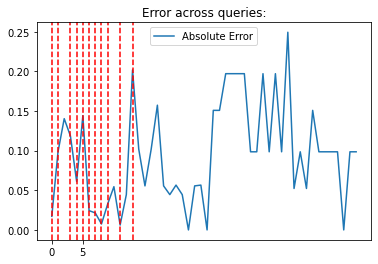

In [15]:
alice_labels = ['Alice'] * 25

alice_error_list = []
random_array = np.random.randint(2, size=(25,4))
zero_array = np.zeros((25,4))
alice = np.hstack((random_array, zero_array))
bob = np.hstack((zero_array, random_array))
alice_query_data = pmw2(workload=np.vstack((alice, bob)), x=x_small, eps=1, T=40, k=10, to_return='pd', 
              analyst_labels=['Alice'] * 25 + ['Bob'] * 25, show_plot=True)
print(f"Alice's total error individually: {sum(alice_query_data.abs_error)}")
display(alice_query_data)

We've shown that Alice can use up all the privacy budget. 

Next, let's take some of the basic adaptations of pmw and see if we can get the same effects to happen or a similar effect were people get similar results indpenedently

### To Dos: 

instead of having a communal pool of update steps we can do, split the amount of udpate steps we can have across all anlaysts. if your udpate steps are not a multiple of the anlaysts, you can change the number of update steps. 

Look for the same kind of violation where either BOb or alice will have more overall error in the joint case as opposed to the independent case. 

Independent state, you can just use the existing pmw algorihtm .

suggestion: when you split it to their individual settings, give them the same amount of update steps that they would've gotten in the group. 

individually - 1 ep, 5 k. together - 2 ep, 10k. 

### Experiments: 
try to find an example (try both orders: regular pmw, adapted w equal update steps pmw, individual): 
1. disjoint sections (shouldn't be a problem) - prob run multiple trials
2. individual querying the entire dataset. 
3. alice asks singleton, bob asks all range queries
4. [if time] Is total error the right metric? 
    - You might run into a case where you get flat error across all of your queries. You may get a lot worse error on one specific query, but the overall error is better. 

    - Now Alice and Bob care about the same data. Alice eats all the budget (entire database except for last). Bob cares about entire database, but his queries about the last index has higher error. 
    
    
Goals: 
1. regular pmw performs poorly, but adapted pmw works well (prolly in disjoint setting)
2. where both regular/adapted pmw perform poorly

### Experiment 2: Bob

In [ ]:

bob_error_list = []
for i in range(1000):
    random_array = np.random.randint(2, size=(500,4))
    bob = np.hstack((zero_array, random_array))
    bob_query_data = pmw(workload=bob, x=x_small, eps=250, beta=0.2, k=500, to_return='pd', 
                         analyst_labels = bob_labels, show_messages=False)
    bob_error_list.append(sum(bob_query_data.abs_error))
print(f"Bob's total error individually: {round(sum(bob_error_list) / len(bob_error_list), 2)}")

bob_labels = ['Bob'] * 500

bob_error_list = []
random_array = np.random.randint(2, size=(500,4))
bob = np.hstack((zero_array, random_array))
bob_query_data = pmw2(workload=bob, x=x_small, eps=50, T=250, k=500, to_return='pd', 
              analyst_labels=['Bob'] * 500, show_plot=True)
print(f"Bob's total error individually: {sum(bob_query_data.abs_error)}")
display(bob_query_data)

### Experiment 3: Alice and Bob combined

In [ ]:
combined_alice_error_list = []
combined_bob_error_list = []

for i in range(1000):
    random_array = np.random.randint(2, size=(500,4))
    alice = np.hstack((random_array, zero_array))
    bob = np.hstack((zero_array, random_array))
    combined_query_data = pmw(workload=np.vstack((alice, bob)), x=x_small, eps=500, beta=0.2, k=1000, to_return='pd', 
                        analyst_labels = alice_labels + bob_labels, show_messages=False)
    combined_alice_error_list.append(sum(combined_query_data[combined_query_data.analyst=='Alice'].abs_error))
    combined_bob_error_list.append(sum(combined_query_data[combined_query_data.analyst=='Bob'].abs_error))
    
print(f"alice's total error in collective: {round(sum(combined_alice_error_list) / len(combined_alice_error_list), 2)}")
print(f"bob's total error in collective: {round(sum(combined_bob_error_list) / len(combined_bob_error_list), 2)}")

In [ ]:
combined_query_data = pmw(workload=np.vstack((alice, bob)), x=x_small, eps=500, beta=0.2, k=1000, to_return='pd', 
                        analyst_labels = alice_labels + bob_labels, show_messages=False, show_plot=True,
                         show_failure_step=True)

# Results:
#### Experiment 1
- Alice's total error individually: 7.29

#### Experiment 3
- Bob's total error individually: 9.12

#### Experiment 3
- Alice's total error in collective: 3.58
- Bob's total error in collective: 7.90

# Conclusion: 
- Sharing incentive and Non-interference desideratas aren't to be violated. Both Alice and Bob’s total error decrease in the collective. 

# Problems: 
- It is difficult to write an experiment in the current case where the first analyst (Alice) takes up all the $\epsilon$. 
- It is difficult to get update steps unless the $\epsilon$ is an absurdly high number, like 500. 